In [2]:
import torch
import faiss 
import numpy as np
from scipy.io import mmread
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
import torch.optim as optim
from sklearn.cluster import KMeans
import torch_geometric.utils as pyg_utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
#check cuda 
print(torch.cuda.is_available()) 
print(torch.version.cuda)
print(torch.__version__)

True
12.4
2.4.1


In [4]:
rawData = mmread('scRNA.mtx')
coo_matrix = rawData.tocoo()
print(coo_matrix)
print(coo_matrix.shape)

<COOrdinate sparse matrix of dtype 'float64'
	with 86422438 stored elements and shape (34619, 27180)>
  Coords	Values
  (30, 0)	878.85046
  (44, 0)	2636.5513
  (58, 0)	878.85046
  (74, 0)	878.85046
  (77, 0)	878.85046
  (109, 0)	878.85046
  (225, 0)	3515.4019
  (247, 0)	878.85046
  (272, 0)	878.85046
  (273, 0)	1318.2756
  (365, 0)	878.85046
  (366, 0)	2636.5513
  (421, 0)	878.85046
  (431, 0)	1757.7009
  (440, 0)	878.85046
  (442, 0)	5273.1025
  (499, 0)	16698.158
  (594, 0)	878.85046
  (649, 0)	1757.7009
  (688, 0)	878.85046
  (706, 0)	878.85046
  (831, 0)	1757.7009
  (835, 0)	2636.5513
  (867, 0)	878.85046
  (911, 0)	2636.5513
  :	:
  (32162, 27179)	142.14685
  (32202, 27179)	88.841736
  (32298, 27179)	177.68347
  (32423, 27179)	59.227825
  (32425, 27179)	177.68347
  (32564, 27179)	88.841736
  (33015, 27179)	177.68347
  (33454, 27179)	177.68347
  (33504, 27179)	177.68347
  (33538, 27179)	177.68347
  (33578, 27179)	88.841736
  (33636, 27179)	177.68347
  (33647, 27179)	284.01257
  (33

#### Process And Modify Data

In [5]:
def clean_and_split_data(coo_matrix, max_number):
    #get only non-zero values
    total_nnz = coo_matrix.nnz 

    # Ensure max_nnz doesn’t exceed total
    if max_number >= total_nnz:
        raise ValueError(f"max_nnz ({max_number}) must be less than total non-zero elements ({total_nnz})")
    
    rows = coo_matrix.row
    cols = coo_matrix.col
    data = coo_matrix.data
    
    selected_indices = np.arange(max_number)  

    selected = coo_matrix.__class__(
        (data[selected_indices], (rows[selected_indices], cols[selected_indices])),
        shape=coo_matrix.shape
    )
    
    return selected

processed_data = clean_and_split_data(coo_matrix=coo_matrix, max_number=900000)
print(processed_data)

<COOrdinate sparse matrix of dtype 'float64'
	with 900000 stored elements and shape (34619, 27180)>
  Coords	Values
  (30, 0)	878.85046
  (44, 0)	2636.5513
  (58, 0)	878.85046
  (74, 0)	878.85046
  (77, 0)	878.85046
  (109, 0)	878.85046
  (225, 0)	3515.4019
  (247, 0)	878.85046
  (272, 0)	878.85046
  (273, 0)	1318.2756
  (365, 0)	878.85046
  (366, 0)	2636.5513
  (421, 0)	878.85046
  (431, 0)	1757.7009
  (440, 0)	878.85046
  (442, 0)	5273.1025
  (499, 0)	16698.158
  (594, 0)	878.85046
  (649, 0)	1757.7009
  (688, 0)	878.85046
  (706, 0)	878.85046
  (831, 0)	1757.7009
  (835, 0)	2636.5513
  (867, 0)	878.85046
  (911, 0)	2636.5513
  :	:
  (14359, 264)	241.19199
  (14367, 264)	96.47679
  (14368, 264)	24.119198
  (14369, 264)	24.119198
  (14374, 264)	48.238396
  (14376, 264)	120.59599
  (14379, 264)	96.47679
  (14382, 264)	24.119198
  (14383, 264)	48.238396
  (14402, 264)	24.119198
  (14403, 264)	24.119198
  (14410, 264)	120.59599
  (14412, 264)	48.238396
  (14414, 264)	48.238396
  (14417, 

Graph Data Object

In [6]:
def cell_graph(data, threshold):

    gene_expression = data.data
    
    x = np.asarray(gene_expression, dtype=np.float32)
    x = x.reshape(-1, 1)


    gpu_resource_manager = faiss.StandardGpuResources() 
    similarity_object = faiss.IndexFlatL2(1)
    similarity_object_in_gpu = faiss.index_cpu_to_gpu(gpu_resource_manager, 0, similarity_object)


    print(similarity_object_in_gpu.is_trained)  
    print(f"FAISS index type: {type(similarity_object_in_gpu)}") 


    similarity_object_in_gpu.add(x)
    k=2
    distances, indices = similarity_object_in_gpu.search(x, k + 1)
    
    edge_index_list = []
    outliers = []
    
    for i in range(len(gene_expression)):
        nearest_neighbors = indices[i, 1:k+1]  
        neighbor_distances = distances[i, 1:k+1]
        
        for j, dist in zip(nearest_neighbors, neighbor_distances):
            if dist <= threshold ** 2:
                edge_index_list.append((i, j))
            else:
                outliers.append(int(j))
    

    edge_index_np = np.array(edge_index_list).T
    edge_index = torch.tensor(edge_index_np, dtype=torch.long) if edge_index_np.size > 0 else torch.empty((2, 0), dtype=torch.long)

    cleaned_outliers = list(set(outliers))
    print(cleaned_outliers)

    x_tensor = torch.tensor(x, dtype=torch.float32)
    pyg_data = Data(edge_index=edge_index, x=x_tensor)
    print(pyg_data)
    return pyg_data

data = cell_graph(data=processed_data,threshold=500)

True
FAISS index type: <class 'faiss.swigfaiss.GpuIndexFlat'>
[397700, 696586, 223116, 163986, 823956, 4763, 490399, 333091, 177955, 747556, 284331, 157360, 283697, 24500, 340662, 703416, 845753, 223163, 372669, 774463, 395840, 538689, 744770, 291661, 217679, 341846, 617691, 507749, 507750, 744808, 877161, 696554, 321899, 75244, 642539, 552686, 659695, 800882]
Data(x=[900000, 1], edge_index=[2, 1799946])


Graph Neural Network

In [7]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=2):
        super(GraphSAGE, self).__init__()
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))  
        
        for _ in range(num_layers - 2):  
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        self.convs.append(SAGEConv(hidden_channels, out_channels))  

    def forward(self, x, edge_index):
        for conv in self.convs[:-1]: 
            x = conv(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=0.5, training=self.training)
        x = self.convs[-1](x, edge_index) 
        return x  

In [ ]:
def contrastive_loss(anchor, positive, negative, margin=1.0):
    pos_dist = torch.norm(anchor - positive, p=2, dim=1) ** 2  
    neg_dist = torch.norm(anchor - negative, p=2, dim=1) ** 2
    loss = torch.clamp(pos_dist - neg_dist + margin, min=0.0).mean()
    return loss


In [ ]:
def train_1(model, data, epochs=100, lr=0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
   

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        embeddings = model(data.x, data.edge_index)  # Forward pass
        loss = triplet_loss(embeddings, pos_pairs, neg_pairs)

        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return embeddings


def train_mse_loss():
    pass

def train_constrastive_loss():
    pass

In [ ]:

model = GraphSAGE(in_channels=1, hidden_channels=64, out_channels=64, num_layers=4)

#run all loss functions
embeddings_loss_1 = train_1(model, data)
# embeddings_loss_2 = tr


AttributeError: 'NoneType' object has no attribute 'backward'

: 

In [ ]:
def cluster_embeddings(embeddings, num_clusters=10):
    """Clusters embeddings using KMeans and returns cluster labels."""
    embeddings_np = embeddings.detach().cpu().numpy()  # Convert to NumPy
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(embeddings_np)  # Run KMeans
    return cluster_labels  # Returns cluster IDs for each cell

# Run clustering
cluster_labels = cluster_embeddings(embeddings_loss_1)
print(cluster_labels) 

NameError: name 'embeddings_loss_1' is not defined

In [ ]:
unique, counts = np.unique(cluster_labels, return_counts=True)
print("Clusters found:", unique)
print("Number of cells per cluster:", counts)

Clusters found: [0 1 2 3 4]
Number of cells per cluster: [887940      1      1      4  12054]


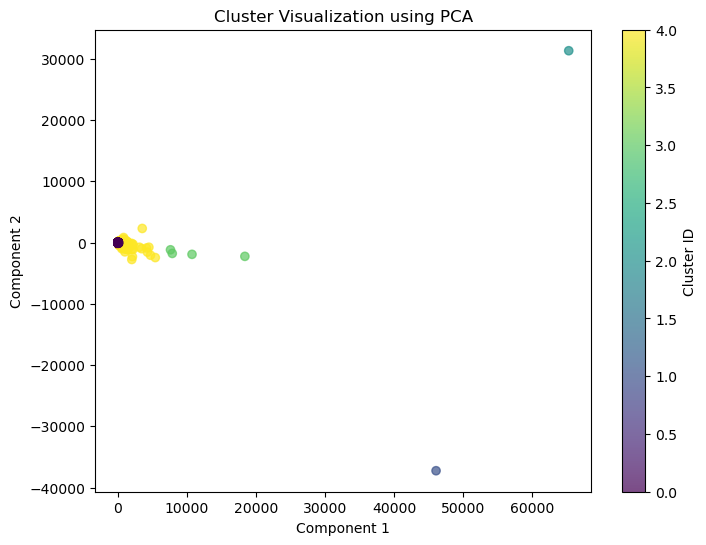

In [ ]:
def plot_clusters(embeddings, cluster_labels):
    """Reduces embeddings to 2D and plots them with cluster colors."""
    embeddings_np = embeddings.detach().cpu().numpy() 

    reducer = PCA(n_components=2)

    reduced_embeddings = reducer.fit_transform(embeddings_np)

    # Plot clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], 
                          c=cluster_labels, cmap='viridis', alpha=0.7)
    
    plt.colorbar(label="Cluster ID")
    plt.title(f"Cluster Visualization using PCA")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.show()


plot_clusters(embeddings_loss_1, cluster_labels, method="pca")
